<a href="https://www.kaggle.com/code/akscent/forkalfabaseline?scriptVersionId=152318620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Baseline

In [4]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
!pip install sweetviz > installer_log.txt
import sweetviz as sv


## Загрузка данных

In [6]:
train_df = pd.read_parquet('/kaggle/input/sibalfahack/Siberian Alfa Hack Materials/Siberian Alfa Hack Materials/train.parquet')
test_df = pd.read_parquet('/kaggle/input/sibalfahack/Siberian Alfa Hack Materials/Siberian Alfa Hack Materials/test.parquet')

In [ ]:
train_df.head()

In [ ]:
test_df.head()

## Обработка данных

Для базовой модели отбросим отдельные таргеты и будем использовать только total_target.

In [9]:
train_df.drop(["id", "target_1", "target_2"], axis=1, inplace=True)
test_df.drop(["id"], axis=1, inplace=True)

Преобразуем тип категориальных признаков

In [10]:
cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]

In [11]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")


In [ ]:
# report = sv.compare_intra(train_df, train_df["total_target"] == 1, ["Target", "Zero"])
# report.show_html('Target 1 vs target 0.html')

# report = sv.analyze(X_test)
# report.show_html("sweetviz_report_test.html")

In [ ]:
pd.set_option('display.max_rows', None)
train_df.isnull().sum()

In [ ]:
pd.reset_option('display.max_rows')

# NA > 200 000

/tmp/ipykernel_47/1020855069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['total_target'] = train_df['total_target']


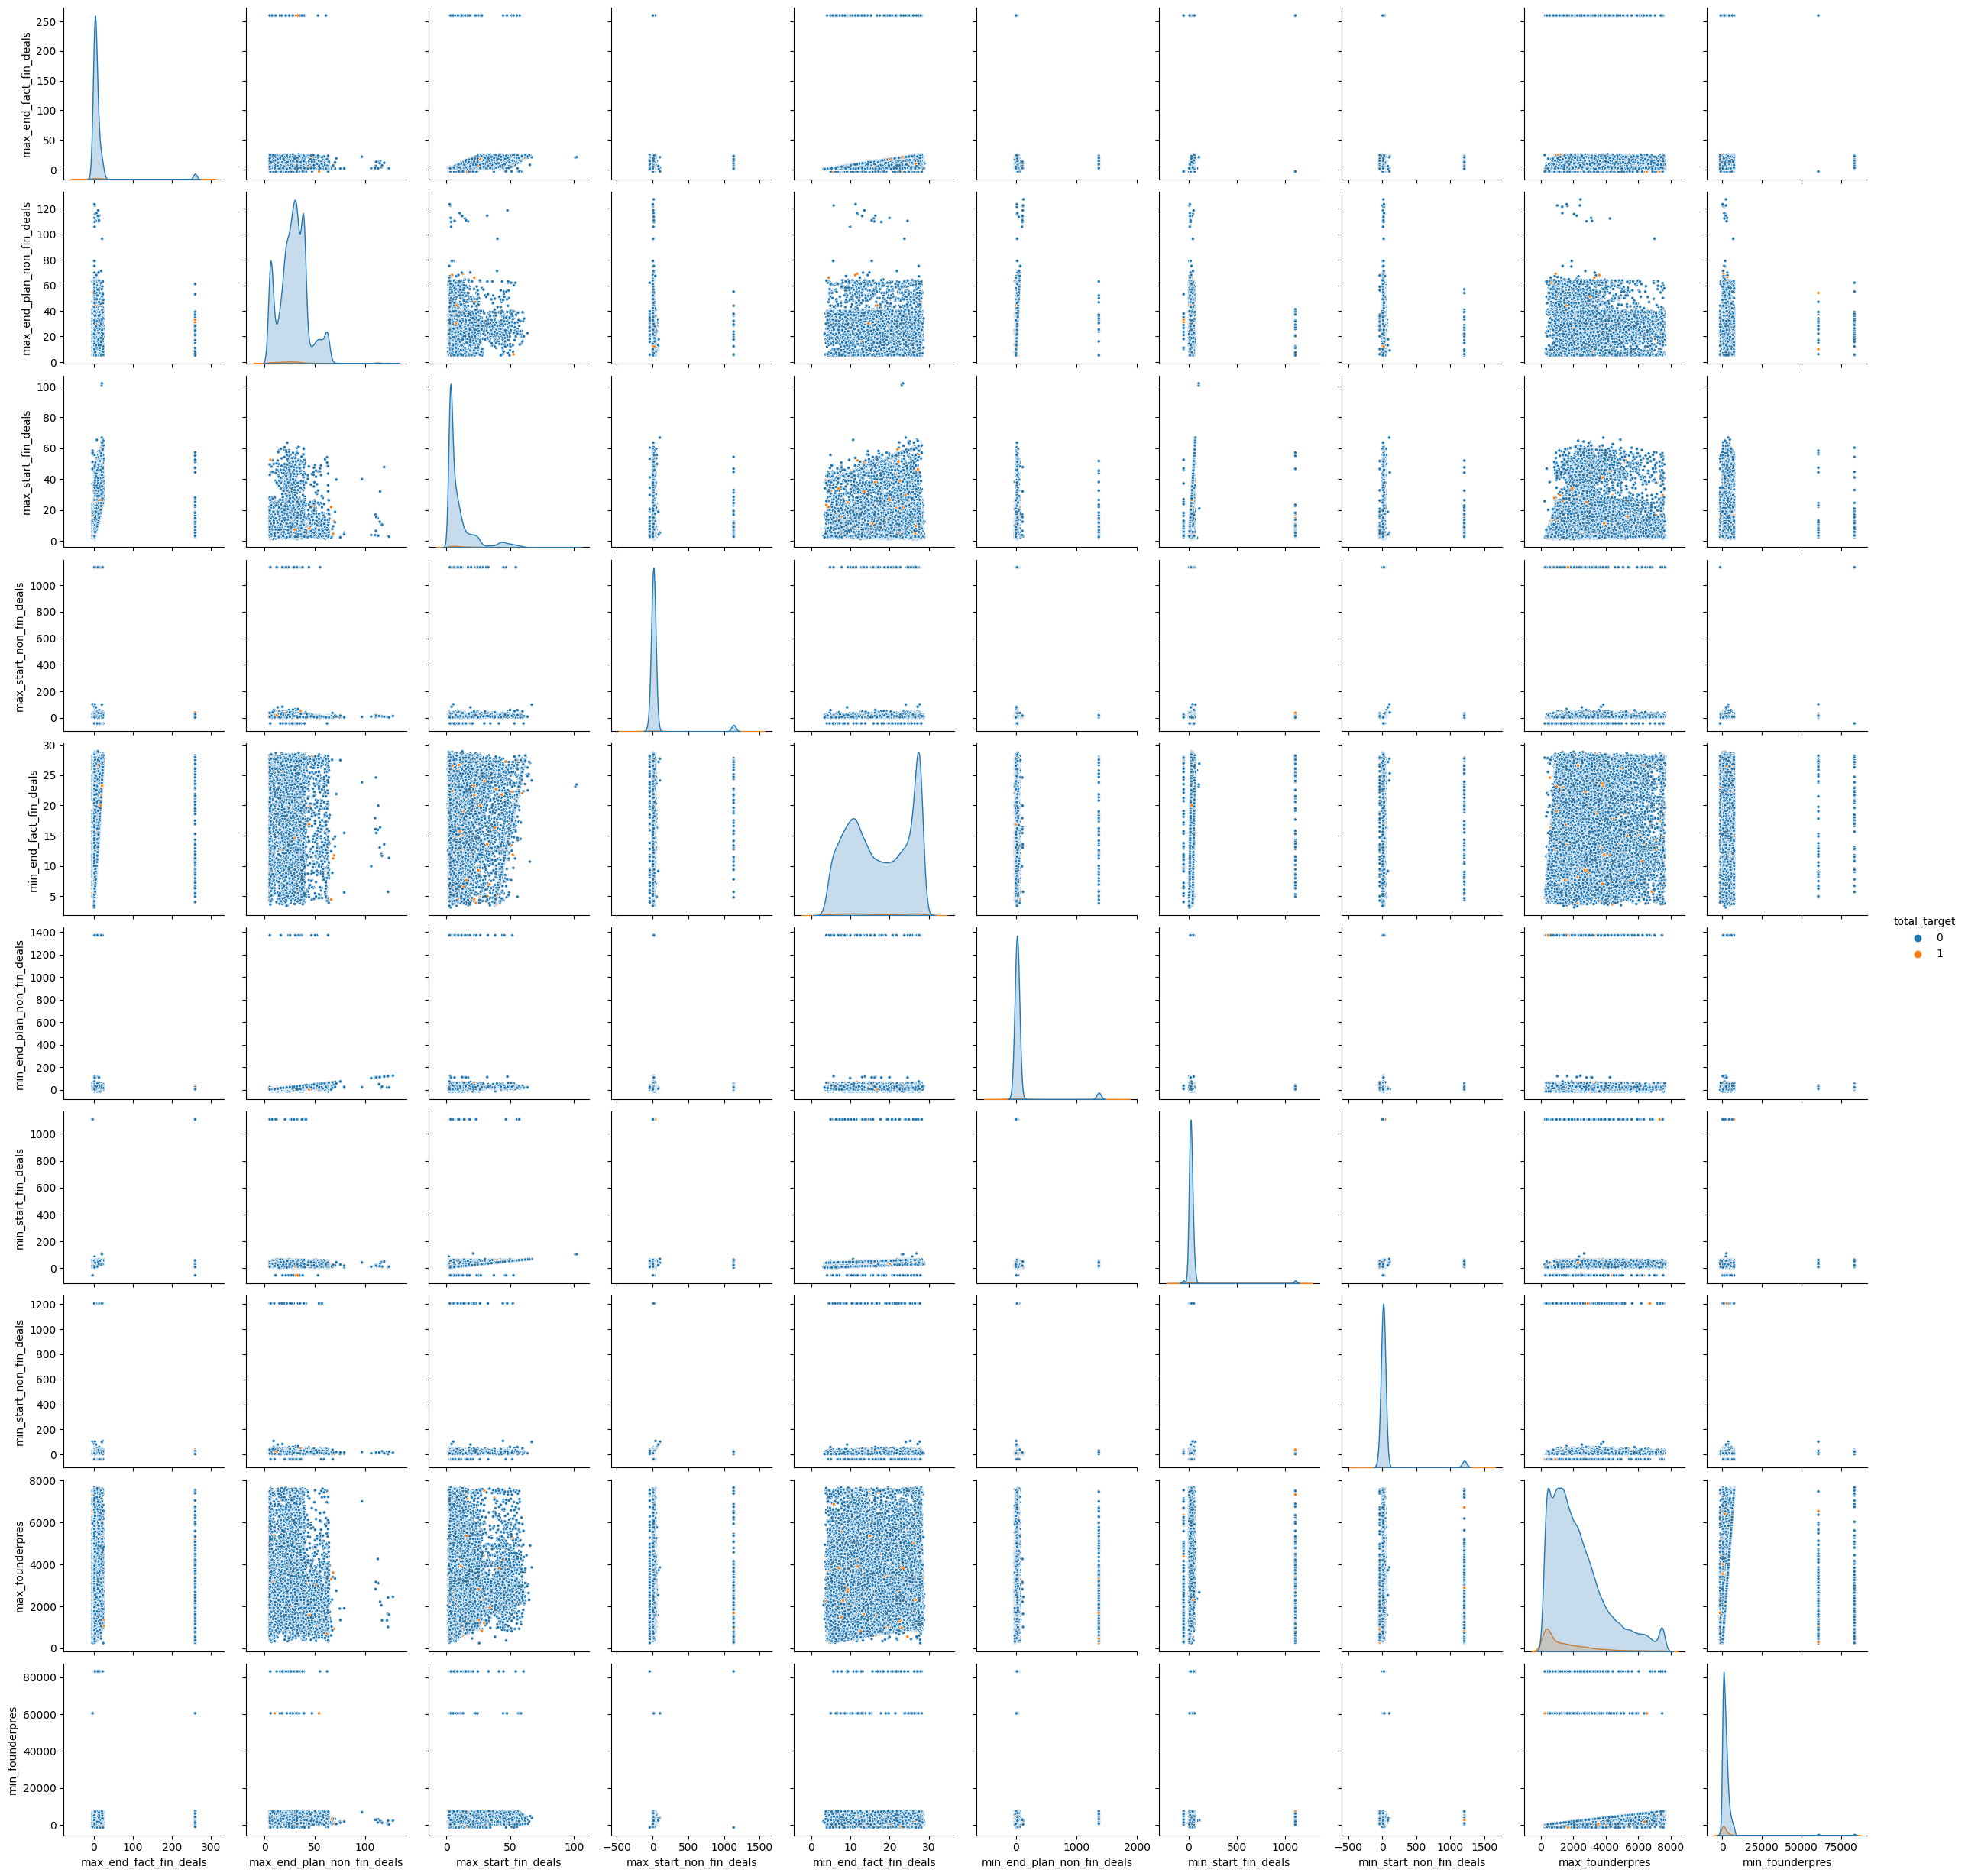

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_with_missing_values = train_df.columns[train_df.isnull().sum() > 200000]
columns_with_missing_values = columns_with_missing_values.append(pd.Index(['total_target']))
subset_df = train_df[columns_with_missing_values]
subset_df['total_target'] = train_df['total_target']
subset_df = subset_df.dropna(subset=['total_target'])
sns.pairplot(subset_df, hue='total_target', diag_kind='kde', markers='.')
plt.show()


In [13]:
count_ones = subset_df['total_target'].sum()
print(f"Количество единиц в столбце 'total_target': {count_ones}")

Количество единиц в столбце 'total_target': 25315


In [ ]:
def visualize_all_columns_distribution(df, target_column):
    columns_to_visualize = df.columns.difference([target_column])
    for column in columns_to_visualize:
        df_subset = pd.DataFrame({column: df[column], target_column: df[target_column]})
        df_subset = df_subset.dropna()
        count_ones = df_subset[target_column].sum()
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df_subset, x=column, hue=target_column, bins=30, kde=True)
        plt.title(f'Distribution of "{column}" (Total Target: {count_ones} ones)')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.legend(title=target_column)
        plt.show()

visualize_all_columns_distribution(subset_df, 'total_target')


In [14]:
def columns_with_few_ones(df, target_column, threshold=1000):
    columns_to_check = df.columns.difference([target_column])
    selected_columns = []
    for column in columns_to_check:
        df_subset = pd.DataFrame({column: df[column], target_column: df[target_column]})
        df_subset = df_subset.dropna()
        count_ones = df_subset[target_column].sum()
        if count_ones < threshold:
            selected_columns.append(column)

    return selected_columns

selected_columns = columns_with_few_ones(subset_df, 'total_target', threshold=1000)
print("Selected Columns:", selected_columns)

Selected Columns: ['max_end_fact_fin_deals', 'max_end_plan_non_fin_deals', 'max_start_fin_deals', 'max_start_non_fin_deals', 'min_end_fact_fin_deals', 'min_end_plan_non_fin_deals', 'min_start_fin_deals', 'min_start_non_fin_deals']


In [15]:
train_df = train_df.drop(columns = selected_columns)
train_df = train_df.drop(columns = ["city", "cnt_deb_d_oper_3m"])

test_df = test_df.drop(columns = selected_columns)
test_df = test_df.drop(columns = ["city", "cnt_deb_d_oper_3m"])

In [17]:
threshold = 20000
city_counts = train_df['city_type'].value_counts()
selected_categories = city_counts[city_counts > threshold].index.tolist()
train_df['city_type'] = train_df['city_type'].apply(lambda x: x if x in selected_categories else 'other')
test_df['city_type'] = test_df['city_type'].apply(lambda x: x if x in selected_categories else 'other')

In [18]:
cat_cols = [
    'channel_code', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [ ]:
train_df = train_df.drop_duplicates()

In [ ]:
train_df.shape

In [19]:
def fill_na_with_group_median(df, cat_cols):
    filled_df = df.copy()
    for column in df.select_dtypes(include='number').columns:
        if df[column].isnull().any():
            temp_df = pd.DataFrame({column: df[column]})
            for cat_col in cat_cols:
                temp_df[cat_col] = df[cat_col]

            group_means = temp_df.groupby(cat_cols)[column].transform('mean')
            filled_df[column] = filled_df[column].combine_first(group_means).fillna(0)

    return filled_df

filled_df = fill_na_with_group_median(train_df, cat_cols)

filled_df_test = fill_na_with_group_median(test_df, cat_cols)

In [20]:
def fill_missing_categorical(df):
    categorical_features = df.select_dtypes(include=['category']).columns
    
    for feature in categorical_features:
        df[feature] = df[feature].astype('object')
        df[feature].fillna(-1, inplace=True)
        df[feature] = df[feature].astype('category')
    
    return df

filled_df = fill_missing_categorical(filled_df)

filled_df_test = fill_missing_categorical(filled_df_test)

In [21]:
filled_df_test.isnull().sum().max()

0

## Разбиение на train, validation

In [ ]:
from sklearn.preprocessing import StandardScaler

X = filled_df.drop("total_target", axis=1)
y = filled_df.total_target
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42, stratify=y)

columns_to_normalize = [col for col in x_train.columns if col not in cat_cols + ["total_target"]]

scaler = StandardScaler()

x_train[columns_to_normalize] = scaler.fit_transform(x_train[columns_to_normalize])
x_val[columns_to_normalize] = scaler.transform(x_val[columns_to_normalize])

## Обучение базовой модели

In [ ]:
!pip install --upgrade -q wandb > installer_log.txt

In [ ]:

import wandb

wandb.login()

В качестве базовой модели возьмем LGBMClassifier

In [ ]:
import lightgbm
from wandb.lightgbm import wandb_callback, log_summary
from sklearn.metrics import f1_score, accuracy_score

CONFIG = dict ()

CONFIG['model_name'] = 'LGBMClassifer'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(project='AlfaSibHack',
                 config=CONFIG,
                 group='Baseline', 
                 job_type='train')

bst_params = {
        'learning_rate': 0.1,
        'min_child_weight': 100,
        'n_estimators': 1250,
        'random_state': 42,
        'reg_alpha': 0,
        'reg_lambda': 0,
    }
run.config.update(bst_params)
run.config.update({'early_stopping_rounds': 400})


model = lightgbm.LGBMClassifier(**bst_params)

model.fit(x_train, y_train, eval_set=[(x_val, y_val)], 
             early_stopping_rounds=run.config['early_stopping_rounds'],
             verbose=-1, callbacks=[wandb_callback()])

model_name = f'{run.name}_model.mod'
bstr = model.booster_
bstr.save_model(model_name)
config = model.get_params()
model_art = wandb.Artifact(name=model_name, type='model', metadata=config)
model_art.add_file(model_name)
run.log_artifact(model_art)

run.summary["best_score"] = bstr.best_score
run.summary["best_iteration"] = bstr.best_iteration
preds = model.predict(x_val)
run.summary["f1_score"] = f1_score(y_val, preds, average='macro')
run.summary["accuracy"] = accuracy_score(y_val, preds)

run.finish()

In [ ]:
y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

In [ ]:
import numpy as np

feature_importance = pd.DataFrame({'feature': model.feature_name_, 'importance': model.feature_importances_})
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)
threshold = 1.5 * np.median(feature_importance_sorted['importance'])
selected_features = feature_importance_sorted[feature_importance_sorted['importance'] > threshold]

print(selected_features)
selected_features_cols = list(selected_features["feature"])

In [ ]:
# import lightgbm as lgb
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score

# def select_features_rfe_lgbm(X, y, n_features=20):
#     """
#     Извлекает лучшие n_features фичей с использованием RFECV и LightGBM.

#     Параметры:
#     - X: pandas.DataFrame, входные признаки
#     - y: pandas.Series, целевая переменная
#     - n_features: int, количество фичей для извлечения (по умолчанию 20)

#     Возвращает:
#     - selected_features: list, список выбранных фичей
#     """

#     model = lgb.LGBMClassifier()
#     categorical_cols = X.select_dtypes(include=['object', 'category']).columns
#     X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
#     rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
#     rfecv.fit(X_encoded, y)

#     selected_feature_indices = rfecv.get_support(indices=True)
#     selected_features = list(X.columns[selected_feature_indices][:n_features])

#     return selected_features

# selected_features_lgbm = select_features_rfe_lgbm(x_train, y_train, n_features=20)
# print("Выбранные фичи:", selected_features_lgbm)


## Выгрузка результатов

In [ ]:
test_df[cat_cols] = test_df[cat_cols].astype("category")
test_df = test_df[list(x_train.columns)]
test_df[columns_to_normalize] = scaler.fit_transform(test_df[columns_to_normalize])

In [ ]:
test_score = model.predict_proba(test_df)[:, 1]

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/sibalfahack/Siberian Alfa Hack Materials/sample_submission.csv")

In [ ]:
sample_submission_df.head()

In [ ]:
sample_submission_df["score"] = test_score

In [ ]:
sample_submission_df.head()

In [ ]:
sample_submission_df.to_csv("my_submission1.csv", index=False)

In [23]:
X.to_csv("X_train_v1.csv", index=False)
y.to_csv("y_train_v1.csv", index=False)
filled_df_test.to_csv("test_v1.csv", index=False)

In [22]:
filled_df_test

,rko_start_months,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
0,61.061808,2.735668e+04,7.416109e+04,255.723506,3.343082e+04,34,-1,-1,12.170908,52.804632,...,0.531871,51005.755087,4.275226,4.257042,33195.968822,1.229488,0.359263,3.014421e+05,7.049883,7.069157
1,16.803743,1.654578e+06,1.729187e+06,2265.723506,1.660652e+06,37,3597,212,22.170908,62.804632,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,1.257277e+05,1.049883,1.069157
2,15.448904,5.315305e+04,9.921213e+04,26294.763506,5.922719e+04,7,-1,-1,19.170908,90.804632,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,1.257277e+05,1.049883,1.069157
3,11.287614,7.648909e+04,1.224288e+05,49710.403506,8.256323e+04,32,-1,-1,10.170908,81.804632,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,1.257277e+05,1.049883,1.069157
4,7.997291,9.232664e+04,1.755382e+05,255.723506,9.840078e+04,37,3597,31,31.170908,41.804632,...,0.531871,11.888083,0.275226,0.257042,135758.248681,2.229488,1.359263,1.267421e+05,2.049883,2.069157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,19.836001,6.167157e+04,1.074278e+06,1558.973506,6.774571e+04,32,-1,-1,4.170908,14.804632,...,1.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,1.257277e+05,1.049883,1.069157
99996,49.319872,3.669695e+04,1.049396e+05,255.723506,4.277109e+04,4,3597,-1,22.170908,32.804632,...,65.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,1.257277e+05,1.049883,1.069157
99997,43.965033,5.108252e+05,7.500329e+05,423093.533506,5.168994e+05,26,-1,-1,4.170908,14.804632,...,0.531871,11.888083,0.275226,0.257042,76611.048681,6.229488,5.359263,1.257277e+05,1.049883,1.069157
99998,38.255356,4.560422e+04,9.160741e+04,18450.043506,5.167836e+04,4,-1,-1,3.170908,44.804632,...,3.531871,15005.755087,1.275226,1.257042,33195.968822,1.229488,0.359263,1.257277e+05,1.049883,1.069157
